In [1]:
#All the required imports
import requests
import json
from pymongo import MongoClient
import pandas as pd
import datetime as dt
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import psycopg2
import csv
import numpy as np
import datetime as dt

In [2]:
#Take input from the user for the year and accordingly fetch the data from API
baseurl = "https://data.cityofnewyork.us/resource/qgea-i56i.json?$$app_token=wK7SaysF0k1J53sWS6fKyaxT0"
# year based on input 
count_url = "&$select=count(cmplnt_num)"
year = input("Please type the year for which analysis to be done. The year should be between 2012 to 2018.")
year_url = "&$where=date_extract_y(cmplnt_fr_dt) in (" + year + ")"

Please type the year for which analysis to be done. The year should be between 2012 to 2018.2018


In [3]:
#Fetch count of existing records from API.
try:
    urlfinal = baseurl + year_url + count_url
    response = requests.get(urlfinal)
    complaint_count = json.loads(response.text)
    total_count = complaint_count[0]['count_cmplnt_num']
except:
    print(response.status_code)
    print("Error in fetching data from API. Data not found.")


#Retrieveing all the data for the year.
limit_url = "&$limit="+str(total_count)

#Connect to MongoDB
mdb_client = MongoClient("mongodb://localhost:27017/")
#Create Database
project_db = mdb_client["NewYorkData"]
#Create Collection
complaint_col = project_db["ComplaintsCollection"]

#If records already present in MongoDB. Cleaning up the previous records.
existing_records_count = complaint_col.find().count()
if (existing_records_count > 0):
    complaint_col.remove()


page_url = baseurl+year_url+limit_url
page_response = requests.get(page_url)
complaint_data = json.loads(page_response.text)
#Count the number of records fetched from API
fetched_records_count = len(complaint_data)
print(fetched_records_count)
#Insert data to the ComplaintsCollection
inserted_records = complaint_col.insert_many(complaint_data)
inserted_records_count = len(inserted_records.inserted_ids)
print(fetched_records_count == inserted_records_count)

#Check count of inserted records
inserted_count = complaint_col.find().count()
print(inserted_count)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning:

count is deprecated. Use Collection.count_documents instead.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning:

remove is deprecated. Use delete_one or delete_many instead.



452997
True
452997


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: DeprecationWarning:

count is deprecated. Use Collection.count_documents instead.



In [4]:
#Connect to MongoDB
mdb_client = MongoClient("mongodb://localhost:27017/")
#Create Database
project_db = mdb_client["NewYorkData"]
#Create Collection
complaint_col = project_db["ComplaintsCollection"]
#Fetching data from MongoDB and converting into DataFrame.
complaints_df = pd.DataFrame(list(complaint_col.find()))

In [5]:
#Preprocessing and cleaning the data.
#Dropping some unneccessary fields
complaints_df.drop(['_id','cmplnt_to_dt','cmplnt_to_tm','parks_nm','hadevelopt','housing_psa',
                   'transit_district','station_name','loc_of_occur_desc','lat_lon','x_coord_cd','y_coord_cd'], axis=1, inplace=True)

#Imputing age_group by using a normal distribution
np.random.seed(100)
complaints_df.loc[~complaints_df["susp_age_group"].isin(['<18','25-44','45-64','18-24','65+']),
                 "susp_age_group"] = np.nan
randomInts = np.random.normal(loc=0, scale=0.6, size= complaints_df.susp_age_group.isnull().sum()).astype(int)
complaints_df.susp_age_group[complaints_df['susp_age_group'].isnull()] = randomInts
complaints_df.replace({-2:'<18',0:'25-44',1:'45-64',-1:'18-24',2:'65+'},inplace=True)

#Imputing susp race randomly
np.random.seed(100)
complaints_df.loc[complaints_df["susp_race"].isin(['UNKNOWN']),"susp_race"] = np.nan
rand_int = np.random.randint(0,6,size = complaints_df.susp_race.isnull().sum())
complaints_df.susp_race[complaints_df['susp_race'].isnull()] = rand_int
complaints_df.susp_race.replace({0:'WHITE HISPANIC',1:'BLACK',2:'WHITE',3:'BLACK HISPANIC',
                      4:'ASIAN / PACIFIC ISLANDER',5:'AMERICAN INDIAN/ALASKAN NATIVE'},inplace=True)

#Imputing victim age group randomly
np.random.seed(100)
complaints_df.loc[~complaints_df["vic_age_group"].isin(['<18','25-44','45-64','18-24','65+']),
                 "vic_age_group"] = np.nan
randomInts = np.random.normal(loc=0, scale=0.6, size= complaints_df.vic_age_group.isnull().sum()).astype(int)
complaints_df.vic_age_group[complaints_df['vic_age_group'].isnull()] = randomInts
complaints_df.replace({-2:'<18',0:'25-44',1:'45-64',-1:'18-24',2:'65+'},inplace=True)

# #Imputing Victim race randomly
np.random.seed(100)
complaints_df.loc[complaints_df["vic_race"].isin(['UNKNOWN']),"susp_race"] = np.nan
rand_int = np.random.randint(0,6,size = complaints_df.vic_race.isnull().sum())
complaints_df.vic_race[complaints_df['vic_race'].isnull()] = rand_int
complaints_df.vic_race.replace({0:'WHITE HISPANIC',1:'BLACK',2:'WHITE',3:'BLACK HISPANIC',
                      4:'ASIAN / PACIFIC ISLANDER',5:'AMERICAN INDIAN/ALASKAN NATIVE'},inplace=True)

##Imputing susp sex randomly
np.random.seed(100)
complaints_df.loc[complaints_df["susp_sex"].isin(['U']),"susp_sex"] = np.nan
rand_int = np.random.randint(0,2,size = complaints_df.susp_sex.isnull().sum())
#elem,counts = np.unique(rand_int,return_counts = True)
complaints_df.susp_sex[complaints_df['susp_sex'].isnull()] = rand_int
complaints_df.susp_sex.replace({0:'M',1:'F'},inplace=True)

## As a very small percentage of other data is missing, just dropping those rows
complaints_clean_df = complaints_df.dropna()

complaints_clean_df["day"] = complaints_clean_df["cmplnt_fr_dt"].apply(lambda x:  dt.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%f").strftime("%A")) # Convert the format
complaints_clean_df["month"] = complaints_clean_df["cmplnt_fr_dt"].apply(lambda x:  dt.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%f").strftime("%B")) # Convert the format
complaints_clean_df["month_number"] = complaints_clean_df["cmplnt_fr_dt"].apply(lambda x:  dt.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%f").strftime("%m")) # Convert the format
complaints_clean_df['cmplnt_fr_dt'] = pd.to_datetime(complaints_clean_df.cmplnt_fr_dt)
#complaints_clean_df['cmplnt_fr_dt'] = pd.to_datetime(complaints_clean_df.cmplnt_fr_dt)

#Exporting Cleaned data to csv
#complaints_clean_df.to_csv ('cleaned_complaints_data.csv', index = None, header=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

In [7]:
#ConnectToPostgres and create database
try:
    dbConnection = psycopg2.connect(
    user = "postgres",
    password = "dublin",
    host = "127.0.0.1",
    port = "5432",
    database = "postgres")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    dbCursor.execute('CREATE DATABASE NewYorkData;')   #Creating Database
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection): dbConnection.close()

In [34]:
#Create Required Tables
try:
    dbConnection = psycopg2.connect(
    user = "postgres",
    password = "dublin",
    host = "127.0.0.1",
    port = "5432",
    database = "newyorkdata")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    dbCursor.execute("""
                     CREATE TABLE Complaints(
                             cmplnt_num varchar(50) PRIMARY KEY,
                             cmplnt_fr_dt date , 
                             cmplnt_fr_tm time , 
                             addr_pct_cd varchar(100), 
                             rpt_dt varchar(100),
                             ky_cd varchar(100),
                             ofns_desc varchar(100),
                             pd_cd varchar(100),
                             pd_desc varchar(100),
                             crm_atpt_cptd_cd varchar(100),
                             law_cat_cd varchar(100),
                             boro_nm varchar(100),
                             prem_typ_desc varchar(100),
                             juris_desc varchar(100),
                             jurisdiction_code varchar(100),
                             latitude varchar(100),
                             longitude varchar(100),
                             patrol_boro varchar(100),
                             vic_age_group varchar(100),
                             vic_race varchar(100),
                             vic_sex varchar(100),
                             susp_age_group varchar(100),
                             susp_race varchar(100),
                             susp_sex varchar(100),
                             day varchar(100),
                             month varchar(100),
                             month_number int 
                            );
                    """)
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection): dbConnection.close()

In [35]:
#Export to csv and load to postgres
complaint_csv = complaints_clean_df.to_csv ('complaint.csv', index = None, header=True)
try:
    dbConnection = psycopg2.connect(
    user = "postgres",
    password = "dublin",
    host = "127.0.0.1",
    port = "5432",
    database = "newyorkdata")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    with open ('complaint.csv', 'r') as f:
        reader = csv.reader(f)
        next(reader) # Skip the header row.
        for row in reader:
            dbCursor.execute(
            "INSERT INTO complaints VALUES (%s, %s,%s, %s,%s, %s,%s, %s,%s, %s,%s, %s,%s, %s,%s, %s,%s, %s,%s, %s,%s, %s,%s, %s,%s, %s,%s)",
            row
        )
    dbConnection.commit()
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection): dbConnection.close()

AxesSubplot(0.125,0.125;0.775x0.755)


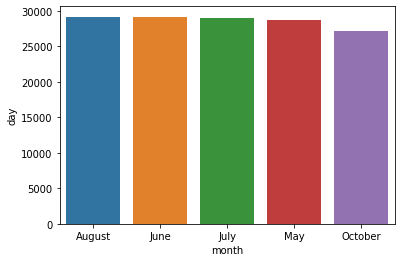

In [35]:
#This is the bragraph that represents the top 5 months in the year 2018 with maximum number of complaints.
graph_oneDF = complaints_clean_df.groupby("month").count()[["day"]].reset_index()
graph_oneDF = graph_oneDF.sort_values("day", ascending = False)
# print (graph_oneDF)

ax = sns.barplot(x = "month", y = "day", data = graph_oneDF[0:5])
print (ax)

    month_number                       ofns_desc   day
178           06                   HARRASSMENT 2  6060
144           05                   HARRASSMENT 2  6058
208           07                   HARRASSMENT 2  5696
235           08                   HARRASSMENT 2  5649
300           10                   HARRASSMENT 2  5632
..           ...                             ...   ...
47            02            FRAUDULENT ACCOSTING     9
153           05  OTHER STATE LAWS (NON PENAL LA     9
205           07            FRAUDULENT ACCOSTING     9
86            03        OFFENSES INVOLVING FRAUD     6
68            03                 BURGLAR'S TOOLS     4

[380 rows x 3 columns]


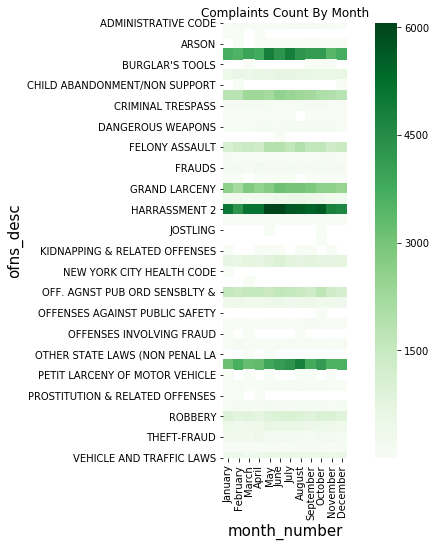

In [37]:
graph_twoDF = complaints_clean_df.groupby(["month_number","ofns_desc"]).count()[["day"]].reset_index()
graph_twoDF = graph_twoDF.sort_values("day", ascending = False)
print (graph_twoDF)
graph_twoDF = graph_twoDF.pivot("ofns_desc","month_number","day")
plt.figure(figsize=(10, 8))
x_axis_labels = ['January','February','March','April','May','June','July','August','September','October','November','December']
plt.ylabel('Month of the Year', size=15)
plt.xlabel('Offence Name',size = 15)
plt.title('Complaints Count By Month')
sns.heatmap(graph_twoDF, square =True,  xticklabels=x_axis_labels, cmap = 'Greens');

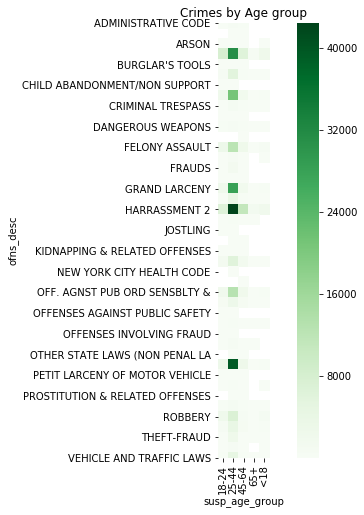

In [38]:
graph_threeDF = complaints_clean_df.groupby(["susp_age_group","ofns_desc"]).count()[["day"]].reset_index()
graph_threeDF = graph_threeDF.sort_values("day", ascending = False)
#print (graph_threeDF)
graph_threeDF = graph_threeDF.pivot("ofns_desc","susp_age_group","day")
plt.figure(figsize=(10, 8))
plt.xlabel('Offence Name',size = 10)
plt.ylabel('Age Group', size=10)
plt.title('Crimes by Age group')
sns.heatmap(graph_threeDF, square =True, cmap = 'Greens');

In [41]:
graphFiveDF = complaints_clean_df.groupby(["vic_race","vic_age_group"]).count()['cmplnt_num'].reset_index()
graphFiveDF = graphFiveDF[graphFiveDF["cmplnt_num"]>0].sort_values(by = "cmplnt_num", ascending = False)

complaintsdic = {}
for keys, values in graphFiveDF.iterrows():
    dictKey = values["vic_age_group"].title()
    if dictKey not in complaintsdic: # Check if the key exist in the dictionary
        complaintsdic[dictKey] = {}
        complaintsdic[dictKey]["x"] = []
        complaintsdic[dictKey]["y"] = []
    
    complaintsdic[dictKey]["x"].append(values["vic_race"].title())    
    complaintsdic[dictKey]["y"].append(values["cmplnt_num"])
# print(admissionType)     

graphList = []
for keys, values in enumerate(complaintsdic):
    graphList.append(go.Bar(
        name = values,
        x = complaintsdic[values]["x"],
        y = complaintsdic[values]["y"]
    ))
fig = go.Figure()
fig = go.Figure(data = graphList)
fig.update_layout(
    title="Victim's Race and Age wise Complaints count ",
    xaxis_title="Victim Race",
    yaxis_title="Count of Complaints"
)
fig.show()

                               ofns_desc    day
18                         HARRASSMENT 2  63675
3           ASSAULT 3 & RELATED OFFENSES  48847
33                         PETIT LARCENY  45615
16                         GRAND LARCENY  32574
7         CRIMINAL MISCHIEF & RELATED OF  25626
12                        FELONY ASSAULT  18619
26         OFF. AGNST PUB ORD SENSBLTY &  17874
38                               ROBBERY  11121
23               MISCELLANEOUS PENAL LAW   9253
5                               BURGLARY   6941
39                            SEX CRIMES   5669
42              VEHICLE AND TRAFFIC LAWS   5396
27        OFFENSES AGAINST PUBLIC ADMINI   4406
17        GRAND LARCENY OF MOTOR VEHICLE   4277
40                           THEFT-FRAUD   2971
14                                FRAUDS   1484
37                                  RAPE   1399
8                      CRIMINAL TRESPASS   1233
10                     DANGEROUS WEAPONS   1017
41         UNAUTHORIZED USE OF A VEHICLE

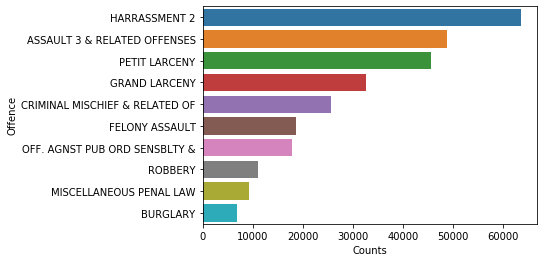

In [40]:
#Top 10 crimes
graph_fiveDF = complaints_clean_df.groupby("ofns_desc").count()[["day"]].reset_index()
graph_fiveDF = graph_fiveDF.sort_values("day", ascending = False)
print (graph_fiveDF)

ax = sns.barplot(x = "day", y = "ofns_desc", data = graph_fiveDF[0:10])
ax.axes.xaxis.label.set_text("Counts")
ax.axes.yaxis.label.set_text("Offence")
print (ax)